In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pdpipe as pdp
import re

In [2]:
re.__version__

'2.2.1'

In [3]:
coor_banco = pd.read_csv('correntistas_banco_bravos (3).csv', encoding = "ISO-8859-1", sep=";",
                         usecols= ['name','male','house','Dívida','Capacidade de pagamento anual'])
coor_obito = pd.read_csv('correntistas_obito (2).csv', encoding = "ISO-8859-1", sep=";")

## Testando pipeline

Nome das casas em ambos dataset tem alguns erros, como House Lannnister e House Lannister, alguns só como Lannister, então é necessário padronizar tudo

In [4]:
coor_banco.house.sort_values().unique()

array(["Alchemists' Guild", 'Antler Men', 'Band of Nine', 'Black Ears',
       'Blacks', 'Brave Companions', 'Brotherhood Without Banners',
       'Brotherhood without Banners', 'Brotherhood without banners',
       'Burned Men', "Chataya's brothel", 'Citadel',
       "City Watch of King's Landing", 'Company of the Cat',
       'Drowned men', 'Faceless Men', 'Faith of the Seven',
       'Golden Company', 'Good Masters', 'Graces', 'Happy Port',
       'House Allyrion', 'House Ambrose', 'House Arryn', 'House Ashford',
       'House Baelish', 'House Ball', 'House Banefort', 'House Bar Emmon',
       'House Baratheon', 'House Baratheon of Dragonstone',
       "House Baratheon of King's Landing", 'House Beesbury',
       'House Belmore', 'House Bettley', 'House Blackbar',
       'House Blackberry', 'House Blackfyre', 'House Blackmont',
       'House Blacktyde', 'House Blackwood', 'House Blanetree',
       'House Blount', 'House Boggs', 'House Bolling', 'House Bolton',
       'House Bolton o

In [5]:
# Converter colunas de valores que estão em string para float
def convert_money(value):
    value = value.split()[-1]
    value = re.sub("[,.]","",value)
    return float(value)

In [6]:
def correct_names(value):
    if pd.isnull(value):
        return "None"
    elif value == 'House Starrkk':
        return "House Stark"
    elif value == 'House Lannnister':
        return 'House Lannister'
    else:
        return value.title()

In [7]:
col_apply = ["Capacidade de pagamento anual","Dívida"]
pipeline = pdp.DropNa(how='all') #<- Drop linha que tem todos valores nan
pipeline += pdp.ApplyByCols(col_apply,convert_money) #<- apply função convert_money nas colunas em col_apply
pipeline += pdp.ApplyByCols('house',correct_names)
coor_banco = pipeline(coor_banco) #<- aplica pipeline do dataframe

In [8]:
coor_banco.house.sort_values().unique()

array(["Alchemists' Guild", 'Antler Men', 'Band Of Nine', 'Black Ears',
       'Blacks', 'Brave Companions', 'Brotherhood Without Banners',
       'Burned Men', "Chataya'S Brothel", 'Citadel',
       "City Watch Of King'S Landing", 'Company Of The Cat',
       'Drowned Men', 'Faceless Men', 'Faith Of The Seven',
       'Golden Company', 'Good Masters', 'Graces', 'Happy Port',
       'House Allyrion', 'House Ambrose', 'House Arryn', 'House Ashford',
       'House Baelish', 'House Ball', 'House Banefort', 'House Bar Emmon',
       'House Baratheon', 'House Baratheon Of Dragonstone',
       "House Baratheon Of King'S Landing", 'House Beesbury',
       'House Belmore', 'House Bettley', 'House Blackbar',
       'House Blackberry', 'House Blackfyre', 'House Blackmont',
       'House Blacktyde', 'House Blackwood', 'House Blanetree',
       'House Blount', 'House Boggs', 'House Bolling', 'House Bolton',
       'House Bolton Of The Dreadfort', 'House Borrell', 'House Botley',
       'House Brac

In [9]:
coor_obito.Allegiances.sort_values().unique()

array(['Arryn', 'Baratheon', 'Greyjoy', 'House Arryn', 'House Baratheon',
       'House Greyjoy', 'House Lannister', 'House Martell', 'House Stark',
       'House Targaryen', 'House Tully', 'House Tyrell', 'Lannister',
       'Martell', "Night's Watch", 'None', 'Stark', 'Targaryen', 'Tully',
       'Tyrell', 'Wildling'], dtype=object)

In [10]:
def allegiances_correction(value):
    if value in ["Wildling","None"]:
        return value
    elif len(value.split())>1:
        return value
    else:
        return f"House {value}"

In [11]:
pipeline2 = pdp.ApplyByCols('Allegiances',allegiances_correction)
coor_obito = pipeline2(coor_obito)

In [12]:
coor_obito.Allegiances.sort_values().unique()

array(['House Arryn', 'House Baratheon', 'House Greyjoy',
       'House Lannister', 'House Martell', 'House Stark',
       'House Targaryen', 'House Tully', 'House Tyrell', "Night's Watch",
       'None', 'Wildling'], dtype=object)

In [13]:
# 1 para pessoa morta e 0 para não morta
for n,ally in zip(coor_obito.Name,coor_obito.Allegiances):
    if coor_banco.name.str.contains(n).sum()>0:
        coor_banco.loc[coor_banco.name==n,'Óbito'] = 1
        coor_banco.loc[coor_banco.name==n,'Allegiances'] = ally
        
coor_banco.loc[coor_banco.Óbito.isna(),"Óbito"] = 0
coor_banco.loc[coor_banco.Allegiances.isna(),"Allegiances"] = "None"

/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


Como cada casa tem uma dívida, podemos subtrair a capacidade de pagamento anual pela dívida para saber quanto de renda efetiva cada casa tem

In [14]:
coor_banco.mean()

male                             6.192189e-01
Dívida                           5.110850e+06
Capacidade de pagamento anual    5.301682e+06
Óbito                            7.759507e-02
dtype: float64

In [15]:
coor_banco.std()

male                             4.857037e-01
Dívida                           2.870191e+06
Capacidade de pagamento anual    3.700777e+06
Óbito                            2.676021e-01
dtype: float64

In [16]:
coor_banco.groupby(by = ['house']).sum().mean()

male                             3.492754e+00
Dívida                           2.882816e+07
Capacidade de pagamento anual    2.990456e+07
Óbito                            4.376812e-01
dtype: float64

In [17]:
coor_banco.groupby(by = ['house']).sum().std()

male                             1.462737e+01
Dívida                           1.281279e+08
Capacidade de pagamento anual    1.304331e+08
Óbito                            2.324609e+00
dtype: float64

Todo tratamento básico dos datasets foram feitos, cuidar de nomes errados, remoção de r$ e etc, agora tratar coisas mais sutis dos dataset.
1. Existem algumas pessoas no dataset principal que tb estão na lista de óbito, essas pessoas serão removidas do dataset (pois pessoa morta não contribui em renda), e sua dívida será igualmente distribuida entre todas pessoas da sua casa e aliança (se ouver alguma).

In [18]:
coor_banco.loc[11,]

name                              Maric Seaworth
male                                           1
house                             House Seaworth
Dívida                                2.7035e+06
Capacidade de pagamento anual         5.3588e+06
Óbito                                          1
Allegiances                      House Baratheon
Name: 11, dtype: object

In [19]:
len(coor_banco[coor_banco.house.isin(['House Seaworth','House Baratheon'])])

22

In [20]:
coor_banco.head(10)

,name,male,house,Dívida,Capacidade de pagamento anual,Óbito,Allegiances
0,Daenerys Targaryen,0.0,House Targaryen,6111500.0,100000000.0,0.0,None
1,Tyrion Lannister,1.0,House Lannister,1210400.0,70000000.0,0.0,None
2,Cersei Lannister,0.0,House Lannister,5415800.0,70000000.0,0.0,None
3,Arya Stark,0.0,House Stark,991600.0,50000000.0,0.0,None
4,Jon Snow,1.0,House Stark,8608400.0,50000000.0,0.0,None
5,Canker Jeyne,0.0,None,4239600.0,6437000.0,0.0,None
6,Dorcas,0.0,House Lannister,3834800.0,7453800.0,0.0,None
7,Lysa Meadows,0.0,House Meadows,567400.0,6149400.0,0.0,None
8,Gerold Lannister,1.0,House Lannister,3067300.0,3031000.0,0.0,None
9,Beldecar,0.0,None,2912300.0,3162600.0,0.0,None


In [21]:
for n in coor_banco.loc[coor_banco.Óbito==1,'name']:
    house = coor_banco.loc[coor_banco.name==n, 'house'].values[0]
    ally = coor_banco.loc[coor_banco.name==n, 'Allegiances'].values[0]
    divida = coor_banco.loc[coor_banco.name==n, 'Dívida'].values[0]

    # primeiramente checar se tem casa ou aliança
    if (house=="None") & (ally=="None"):
        pass
    # dívida distribuida igualmente em todas pessoas vivas dos aliados e casa
    
    # caso pessoa não tenha casa mas aliado
    elif house=="None":
        total = len(coor_banco[(coor_banco.house==ally) & (coor_banco.Óbito==0)])
        d = divida/total
        coor_banco.loc[(coor_banco.house==ally) & (coor_banco.Óbito==0),'Dívida'] +=d
    
    # caso pessoa não tenha aliado mas tenha casa
    elif ally=="None":
        total = len(coor_banco[(coor_banco.house==house) & (coor_banco.Óbito==0)])
        d = divida/total
        coor_banco.loc[(coor_banco.house==house) & (coor_banco.Óbito==0),'Dívida'] +=d
    
    # caso pessoa não ambos
    else:
        total = len(coor_banco[(coor_banco.house==house) & (coor_banco.house==ally) & (coor_banco.Óbito==0)])
        d = divida/total
        coor_banco.loc[(coor_banco.house==house) & (coor_banco.house==ally) & (coor_banco.Óbito==0),'Dívida'] +=d
        

/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


In [22]:
coor_banco.head(10)

,name,male,house,Dívida,Capacidade de pagamento anual,Óbito,Allegiances
0,Daenerys Targaryen,0.0,House Targaryen,6.224284e+06,100000000.0,0.0,None
1,Tyrion Lannister,1.0,House Lannister,2.046580e+06,70000000.0,0.0,None
2,Cersei Lannister,0.0,House Lannister,6.251980e+06,70000000.0,0.0,None
3,Arya Stark,0.0,House Stark,1.924919e+06,50000000.0,0.0,None
4,Jon Snow,1.0,House Stark,9.541719e+06,50000000.0,0.0,None
5,Canker Jeyne,0.0,None,4.239600e+06,6437000.0,0.0,None
6,Dorcas,0.0,House Lannister,4.670980e+06,7453800.0,0.0,None
7,Lysa Meadows,0.0,House Meadows,5.674000e+05,6149400.0,0.0,None
8,Gerold Lannister,1.0,House Lannister,3.903480e+06,3031000.0,0.0,None
9,Beldecar,0.0,None,2.912300e+06,3162600.0,0.0,None


Remover todas pessoas que estão mortas do dataset.

In [23]:
treated_data = coor_banco[coor_banco.Óbito==0].reset_index(drop=True)

Ok, agora temos somente pessoas vivas no dataset, e com a dívida das pessoas mortas distribuidas entre todos membros da família e alianca.

Você é um renomado analista no banco de Bravos e recebeu da alta diretoria a tarefa de criar a curva ABC dos atuais correntistas do banco. Infelizmente, não existe uma integração entre as duas bases de dados disponíveis (correntistas_banco_bravos.csv e correntistas_obito.csv). Dessa forma, todas as contas estão atualmente ativas, não levando em consideração os óbitos. Sabendo disso, crie a curva ABC seguindo as diretrizes do banco informadas abaixo:

 

- A: >= 50%;

- B: >= 20% e < 50%;

- C: <20%;

 

O propósito da análise é demonstrar para os acionistas em quais famílias/alianças há a necessidade de intensificar o investimento para o próximo ano, com base em seu patrimônio previsto para este ano.

In [24]:
treated_data['patrimônio'] = treated_data['Capacidade de pagamento anual'] - treated_data['Dívida']

In [25]:
data_grouped = treated_data.groupby(by='house').sum().sort_values(by='patrimônio',ascending=False).drop(columns=['male','Óbito'])

In [26]:
data_grouped.head(10)

,Dívida,Capacidade de pagamento anual,patrimônio
house,,,
House Lannister,237000800.0,369411500.0,132410700.0
House Targaryen,305806600.0,411189400.0,105382800.0
House Martell,107767000.0,132169700.0,24402700.0
House Waynwood,28278400.0,51698900.0,23420500.0
House Stark,389253100.0,410234600.0,20981500.0
House Webber,18554600.0,38214900.0,19660300.0
House Dayne,11775700.0,30306500.0,18530800.0
House Of Loraq,13810500.0,28735100.0,14924600.0
House Tyrell,174340300.0,188860400.0,14520100.0


In [27]:
data_grouped.tail(10)

,Dívida,Capacidade de pagamento anual,patrimônio
house,,,
Stormcrows,21094900.0,6735700.0,-14359200.0
House Osgrey,115726700.0,101015300.0,-14711400.0
House Crakehall,71097500.0,54119700.0,-16977800.0
House Hightower,97734300.0,80387000.0,-17347300.0
House Arryn,92802500.0,72399800.0,-20402700.0
Faith Of The Seven,95033400.0,73834900.0,-21198500.0
Brave Companions,49688900.0,28307600.0,-21381300.0
Brotherhood Without Banners,128666100.0,104022400.0,-24643700.0
House Bracken,74765700.0,48875400.0,-25890300.0


Agora como temos todas as casas agrupadas por patrimônio, e visto que tem casas com mais dívidas que renda, ou seja patrimônio negativo, essas casas vão ser removidas, pois não são bons para investir.

As casas com patrimônio negativas são

In [28]:
[print(x) for x in data_grouped[data_grouped.patrimônio<0].index]

House Harlaw
House Cupps
House Broom
House Of Pahl
House Woolfield
House Gaunt
House Stokeworth
House Risley
House Harclay
House Farwynd
House Connington
House Leek
House Heddle
House Bulwer
House Frey
House Grell
House Morrigen
House Farwynd Of The Lonely Light
Kingsguard
House Stonehouse
Graces
House Hayford
House Kenning Of Kayce
House Shepherd
Company Of The Cat
House Farring
House Bar Emmon
Kingdom Of The Three Daughters
House Dondarrion
House Longwaters
House Lorch
House Yronwood
Peach
House Norcross
House Fowler
House Yew
House Greenhill
House Baelish
House Blackmont
House Cox
Pureborn
Three-Eyed Crow
House Sparr
Golden Company
House Mallery
House Blount
House Farman
House Jast
Wise Masters
House Wull
Black Ears
House Wode
House Strickland
House Lychester
House Payne
House Jordayne
House Cole
House Moreland
Thenn
House Whent
House Mollen
House Reyne
House Varner
Burned Men
House Strong
House Woods
House Vyrwel
House Lonmouth
House Graceford
House Crabb
House Volmark
House Lannis

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [29]:
data_grouped_positive = data_grouped[data_grouped.patrimônio>0]

In [30]:
data_grouped_positive['patrimônio_percent'] = round(data_grouped_positive['patrimônio']/data_grouped_positive['patrimônio'].sum()*100,2)

/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
data_grouped_positive['cumulative_patri_percent'] = data_grouped_positive['patrimônio_percent'].cumsum()

/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
data_grouped_positive

,Dívida,Capacidade de pagamento anual,patrimônio,patrimônio_percent,cumulative_patri_percent,Class
house,,,,,,
House Lannister,2.370008e+08,369411500.0,132410700.0,13.41,13.41,A
House Targaryen,3.058066e+08,411189400.0,105382800.0,10.68,24.09,A
House Martell,1.077670e+08,132169700.0,24402700.0,2.47,26.56,A
House Waynwood,2.827840e+07,51698900.0,23420500.0,2.37,28.93,A
House Stark,3.892531e+08,410234600.0,20981500.0,2.13,31.06,A
House Webber,1.855460e+07,38214900.0,19660300.0,1.99,33.05,A
House Dayne,1.177570e+07,30306500.0,18530800.0,1.88,34.93,A
House Of Loraq,1.381050e+07,28735100.0,14924600.0,1.51,36.44,A
House Tyrell,1.743403e+08,188860400.0,14520100.0,1.47,37.91,A


In [33]:
def ABC_segmentation(perc):
    '''
    Creates the 3 classes A, B, and C based 
    on quantity percentages (A-60%, B-25%, C-15%)
    '''
    if perc > 0 and perc < 50:
        return 'A'
    elif perc >= 50 and perc < 80:
        return 'B'
    elif perc >= 80:
        return 'C'

In [34]:
data_grouped_positive['Class'] = data_grouped_positive['cumulative_patri_percent'].apply(ABC_segmentation)

/home/igor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
round(len(data_grouped_positive[data_grouped_positive.Class=="A"])/len(data_grouped_positive)*100,2)

11.7

In [36]:
round(len(data_grouped_positive[data_grouped_positive.Class=="B"])/len(data_grouped_positive)*100,2)

30.41

In [37]:
round(len(data_grouped_positive[data_grouped_positive.Class=="C"])/len(data_grouped_positive)*100,2)

57.89

(0, 171)

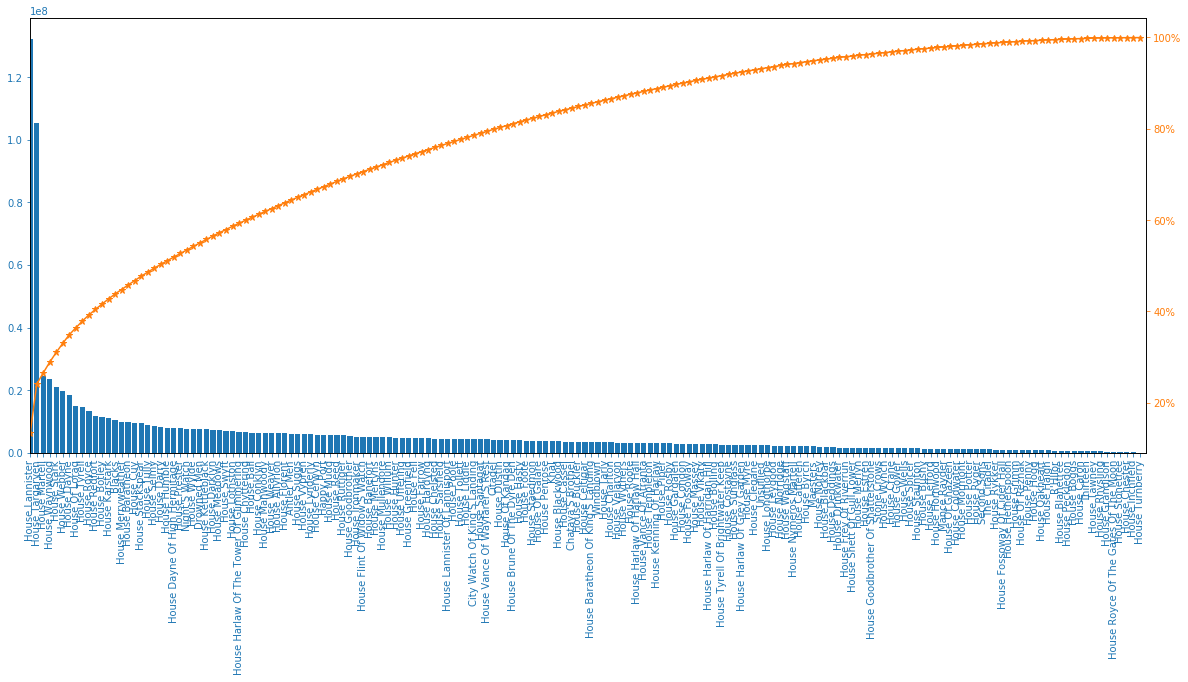

In [56]:
from matplotlib.ticker import PercentFormatter
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(data_grouped_positive.index, data_grouped_positive["patrimônio"], color="C0")
ax2 = ax.twinx()
ax2.plot(data_grouped_positive.index, data_grouped_positive["cumulative_patri_percent"], 
         color="C1", marker="*", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax.tick_params(axis="x", colors="C0",labelrotation=90)
plt.xlim([0,len(data_grouped_positive)])
